<div align=center><h1 style="display: inline;" >1. Manipulating Data (A2)

The central type of data storage in H2O is the H2OFrame. It is similar to the pandas or Spark DataFrame, but makes use of columnar compression. Given the cost of transfering between these forms, there is an advantage to performing data transformations within H2O to the extent possible. Here we demonstrate some such transformations.

**Connecting to H2O:**

In [1]:
import h2o
h2o.init(strict_version_check = False)

[WARNING] H2O requires requests module of version 2.10 or newer. You have version 2.6.0.
You can upgrade to the newest version of the module running from the command line
    $ pip2 install --upgrade requests
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,53 secs
H2O cluster version:,3.14.0.6
H2O cluster version age:,9 days
H2O cluster name:,ec2-user
H2O cluster total nodes:,2
H2O cluster free memory:,1.546 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


**Importing data to an H2OFrame: **

In [2]:
weather_hex = h2o.import_file("hdfs://ec2-34-204-73-232.compute-1.amazonaws.com:9000/31081_New_York_City__Hourly_2013.csv")
weather_hex.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(8760, 50)

**Transforming a H2OFrame column:**

In [3]:
weather_hex["temp_f"] = 1.8 * weather_hex["Temperature (C)"] + 32

**Performing aggregations on an H2OFrame:**

In [4]:
weather_group = weather_hex.group_by(by=["Month Local","Day Local"]).min(col="temp_f", na="ignore").max(col="temp_f", na="ignore").mean(col="temp_f", na="ignore")
temp_hex = weather_group.get_frame()

In [5]:
print "The day with lowest temperature is: "
temp_hex[temp_hex['min_temp_f'].idxmin().flatten(), ['Month Local','Day Local']]

The day with lowest temperature is: 


Month Local,Day Local
1,23


In [6]:
print "The day with highest temperature is: "
temp_hex[temp_hex['max_temp_f'].idxmax().flatten(), ['Month Local','Day Local']]

The day with highest temperature is: 


Month Local,Day Local
7,18


**Exporting an H2OFrame to pandas.** H2O is not a visualization library (although there appears to be functionality for histograms), so we will have to export the dataframe:

In [7]:
temp_df = temp_hex.as_data_frame()

In [8]:
from calendar import monthrange
days_to_month = [0]
for i in range(11):
    days_to_month.append(days_to_month[i]+monthrange(2013,i+1)[1])

temp_df['day_of_year'] = 0
for i in range(len(temp_df)):
   temp_df.loc[i,'day_of_year'] = days_to_month[temp_df.loc[i,'Month Local']-1] + temp_df.loc[i,'Day Local']

/usr/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/lib64/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


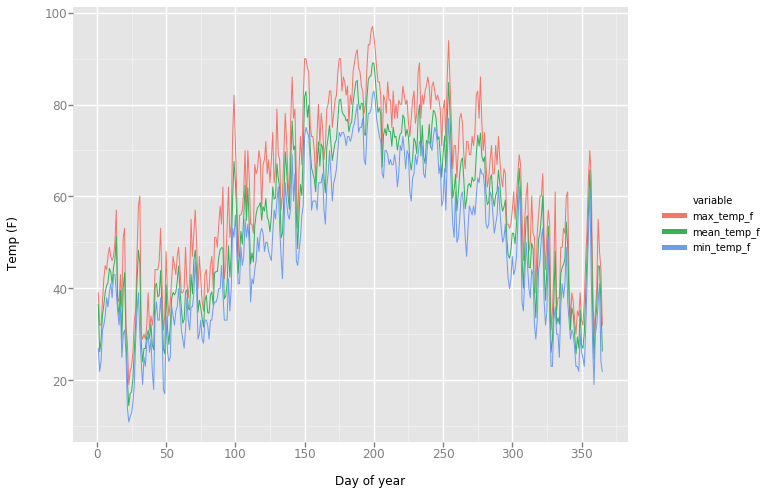

<ggplot: (5330517)>

In [9]:
%matplotlib inline  
from ggplot import *
import pandas as pd
plot_df = pd.melt(temp_df, id_vars='day_of_year', value_vars=['min_temp_f','mean_temp_f','max_temp_f'])
ggplot(aes(x='day_of_year', y='value', color='variable'), data=plot_df) + geom_line() + xlab("Day of year") + ylab("Temp (F)")               